### Cleaning the Lab Results CSV

In [ ]:
#imports
import pandas as pd
import zipfile
import numpy as np

In [ ]:
# Check size of Lab Results CSV
def row_count(input):
    with open(input) as f:
        for i, l in enumerate(f):
            pass
    return i
row_count('lab_result.zip')

In [ ]:
# Filter Lab Results csv for only positive values
iter_csv = pd.read_csv('lab_result.csv', iterator=True, chunksize=1000000)
df = pd.concat([chunk[chunk['lab_result_text_val'] == 'Positive'] for chunk in iter_csv])

In [ ]:
# Filter for COVID LOINC codes
LOINC_code = ['94309-2', '94315-9', '94316-7', '94500-6', '94502-2', '94505-5', '94506-3',
    '94507-1', '94508-9', '94533-7', '94534-5', '94559-2', '94565-9', '94758-0',
    '94759-8', '9088', '9089']

loincdf = df[df['code'].isin(LOINC_code)]

## Cleaning the Diagnosis CSV

In [ ]:
# Filter Diagnosis CSV 
DX_code = ['B34.2', 'B97.29', 'U07.1', 'U07.2', 'J12.81']

iter_csv = pd.read_csv('diagnosis.csv', iterator=True, chunksize=1000000)
df = pd.concat([chunk[chunk['code'].isin(DX_code)] for chunk in iter_csv])

## Appending the Lab Result and Diagnosis Dataframes

In [ ]:
result = df.append(loincdf, ignore_index=True, sort=False)
result = result.sort_values(by=['date']) # sort by first date of COVID diagnosis or positive test
result = result[result['date'] > 20191231] # some patient have a COVID diagnosis prior to 2019, we'll call this a mistake
result = result.drop_duplicates(subset='patient_id', keep="first") # drop duplicates and keep the earliest entry

## Merging the Lab Result x Diagnosis dataframe to the Patient CSV

In [ ]:
# read in the patient csv
df3 = pd.read_csv('patient.zip') 

In [ ]:
# basic stats
df3.describe()

We see that we have over 1.6 million patients!  
The mean age is (2021 - 1974 =) 47, with a standard deviation of 21 years.  
The people who died, usually did at 66, but we have patients who have died as early as 58 or as late as 90.  
Unfortunately, the postal code column is empty, so we wont be able to do any regional analysis :(


In [ ]:
# groupby sex and race
sex = df3.groupby('sex')
race = df3.groupby('race')

In [ ]:
# data visualization: Sex
plt.figure(figsize=(5,5))
sex.size().sort_values(ascending=False).plot.bar()
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

Our study participants are mainly female.

In [ ]:
# data visualization: Race
plt.figure(figsize=(5,5))
race.size().sort_values(ascending=False).plot.bar()
plt.xlabel("Race")
plt.ylabel("Count")
plt.show()

And mostly white.

In [ ]:
# Merge the Diagnosis x Lab Results csv with the patient csv
master = df3.merge(result, how='left', on='patient_id')
master = master[master['code'].notna()] # drop the patients with no COVID 
master = master.drop(['postal_code', 'derived_by_TriNetX', 'lab_result_num_val'], axis=1) # remove unnecessary columns

## Splitting the diagnosis dataset into pre-COVID and post-COVID

In [ ]:
# Make a list of patient ID's, first COVID, and top 200 codes
PID = list(master['patient_id'])
dates = list(master['date'])
codes = pd.read_csv('200_Common_Codes.csv')
code_list = list(codes['Unnamed: 0'])

In [ ]:
# Read in the diagnosis csv and filter by patient ID
iter_csv = pd.read_csv('diagnosis.zip', iterator=True, chunksize=1000000)
df = pd.concat([chunk[chunk['patient_id'].isin(PID)] for chunk in iter_csv])

In [ ]:
# append chunks to an empty list
chunks = []
for i in range(int(0.1 * len(PID))): # 10% of the patients will be used as proof of concept
   chunks.append(df[(df['patient_id'] == PID[i] ) & (df['date']<dates[i])])

# concatenate chunks to df and filter for 200 most common codes 
pre_covid = pd.concat(chunks)
pre_covid = pre_covid[pre_covid['code'].isin(code_list)]

# write to csv
pre_covid.to_csv('pre_covid.csv')


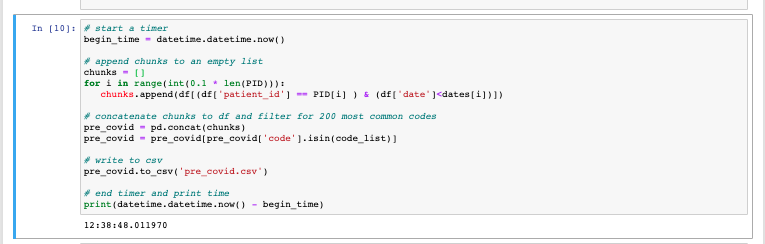

This block of code takes 12 hours to run, we would need over 120 hours to process the whole dataset (just for pre-COVID diagnoses).

In [ ]:
# create a column of 14 days post-COVID diagnosis as integer type
master['datetime'] = pd.to_datetime(master['date'].astype(str), format='%Y%m%d')
master["post_date"] = master.datetime + pd.Timedelta(days=14)
master['post_date'] = pd.to_datetime(master['post_date']).dt.strftime("%Y%m%d")
master['post_date'] = master['post_date'].astype(int)
post_dates = list(master['post_date'])

In [ ]:
# append chunks to an empty list
chunks = []
for i in range(int(0.1 * len(PID))):
   chunks.append(df[(df['patient_id'] == PID[i] ) & (df['date']>dates[i])])

# concatenate chunks to df and filter for 200 most common codes 
post_covid = pd.concat(chunks)
post_covid = post_covid[post_covid['code'].isin(code_list)]

# write to csv
post_covid.to_csv('post_covid.csv')

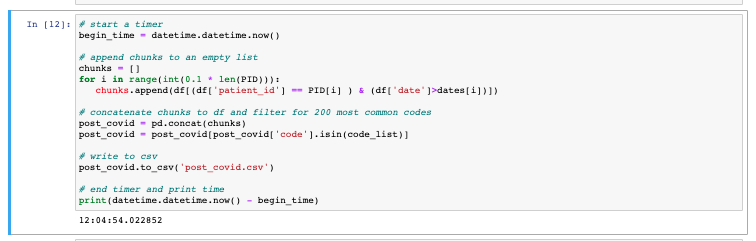

### Mapping diagnosis descriptions to codes and visualizing the results

In [ ]:
# read in terminology csv
term = pd.read_csv('standardized_terminology.csv')

# cleaning
pre = pre_covid.drop_duplicates(subset=['patient_id', 'code'], keep='last')
post = post_covid.drop_duplicates(subset=['patient_id', 'code'], keep='last')
term = term[['code', 'code_description']]

# joining
pre = pd.merge(pre, term, on='code', how='left')
post = pd.merge(post, term, on='code', how='left')

# group by code description
pre_description = pre.groupby(['code_description'])
post_description = post.groupby(['code_description'])

In [ ]:
# Pre-COVID diagnoses
plt.figure(figsize=(20,40))
pre_description.size().sort_values(ascending=True).plot.barh()
plt.xlabel("Count")
plt.ylabel("Diagnosis")
plt.show()

In [ ]:
# Post-COVID diagnoses
plt.figure(figsize=(20,40))
post_description.size().sort_values(ascending=True).plot.barh()
plt.xlabel("Count")
plt.ylabel("Diagnosis")
plt.show()

# Diagnosis Profiling- John

In [ ]:
import pandas as pd
pd.options.display.max_rows=None
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#Following code was found on this stack overflow page: https://stackoverflow.com/questions/44144843/find-number-of-rows-in-large-csv-file-using-python
def row_count(input):
    with open(input) as f:
        for i, l in enumerate(f):
            pass
    return i
row_count('diagnosis.csv')
#This cell calculates the number of rows= 324,179,748

In [ ]:
head=pd.read_csv('diagnosis.csv', nrows=1, header=0)
head.head()

The above code shows the columns for this dataset. Because the we are looking for characteristics of patients with long haul covid both before and after, we will want to drop the ‘encounter_id’ because it contains information about location and provider while we are only interested in the diagnosis and date of the diagnosis for each patient.We will also drop the ‘derived_by_TriNetX’ column because it is also not relevant information for our purposes.

In [ ]:
#The diagnosis.csv file is 39.9 GB is size. To large for this computer to be able to read into a single dataframe.
#By trail and error while also knowing the number of rows in the dataset. I made smaller dataframes that could be handled.
dia=pd.read_csv('diagnosis.csv', nrows=100000000, dtype='object')

In [ ]:
print(dia.shape)
dia=dia.drop_duplicates()
print(dia.shape)

In [ ]:
dia2=pd.read_csv('diagnosis.csv',skiprows=range(1,100000000), nrows=100000000)

In [ ]:
dia=dia.drop(columns=['encounter_id'])
dia=dia.drop(columns=['derived_by_TriNetX'])
dia2=dia2.drop(columns=['encounter_id'])
dia2=dia2.drop(columns=['derived_by_TriNetX'])


In [ ]:
print(dia2.shape)
dia2=dia2.drop_duplicates()
print(dia2.shape)

In [ ]:
item_counts2=dia2['code'].value_counts()

In [ ]:
dia3=pd.read_csv('diagnosis.csv',skiprows=range(1,200000000), nrows=100000000)

In [ ]:
print(dia3.shape)
dia3=dia3.drop_duplicates()
print(dia3.shape)

In [ ]:
dia3=dia3.drop(columns=['encounter_id'])
dia3=dia3.drop(columns=['derived_by_TriNetX'])
item_counts3=dia3['code'].value_counts()

In [ ]:
dia4=pd.read_csv('diagnosis.csv', skiprows=range(1,300000000))

In [ ]:
print(dia4.shape)
dia4=dia4.drop_duplicates()
print(dia4.shape)

In [ ]:
dia4=dia4.drop(columns=['encounter_id'])
dia4=dia4.drop(columns=['derived_by_TriNetX'])
item_counts4=dia4['code'].value_counts()

In [ ]:
#This cell shows the code systems used in this dataset
df_list=[dia, dia2, dia3, dia4]
for i in df_list:
    dia_uc=i['code_system'].unique()
    print(dia_uc)

The above results shows only the code systems 'ICD-10-CM' and 'ICD-9-CM' are used. We need to find if there are any missing entries and determine what to do with them.

In [ ]:
bad_codes=dia[dia['code_system'].isna()]
bad_codes

In [ ]:
bad_codes=dia2[dia2['code_system'].isna()]
bad_codes

In [ ]:
nulls=dia[dia.isna().any(axis=1)]
nulls

In [ ]:
nulls=dia2[dia2.isna().any(axis=1)]
nulls

In [ ]:
nulls=dia3[dia3.isna().any(axis=1)]
nulls

In [ ]:
nulls=dia4[dia4.isna().any(axis=1)]
nulls

There were only 3 entries with missing values for the code system. The most conservative approach is to just drop these rows because we do not know which system they code for and it is only a minimal amount of potential information lost.

In [ ]:
dia=dia.dropna()
dia2=dia2.dropna(

Now we need to make sure that all the code represent good information. To do this we need to check that each code appears in the code system it is associated with. If it is not found in our terminology.csv, we will assume that it was encoded improperly and get rid of it.

In [ ]:
icd9cm=pd.read_csv('ICD9_Codes.csv')
icd10cm=pd.read_csv('ICD10_Codes.csv')

In [ ]:
icd10=icd10cm['code'].tolist()
print(len(icd10))
icd9=icd9cm['code'].tolist()
print(len(icd9))
for i in icd9:
    icd10.append(i)
print(len(icd10))

In [ ]:
x=dia.isin(icd10)
x=x[x['code']==False]
x.shape

In [ ]:
x=dia2.isin(icd10)
x=x[x['code']==False]
x.shape

In [ ]:
x=dia3.isin(icd10)
x=x[x['code']==False]
x.shape

In [ ]:
x=dia4.isin(icd10)
x=x[x['code']==False]
x.shape

In [ ]:
pats=pd.read_csv('patient.csv')

In [ ]:
pats=pats['patient_id'].tolist()

In [ ]:
x=dia.isin(pats)
x=x[x['patient_id']==False]
x.shape

In [ ]:
x=dia2.isin(pats)
x=x[x['patient_id']==False]
x.shape

In [ ]:
x=dia3.isin(pats)
x=x[x['patient_id']==False]
x.shape

In [ ]:
x=dia4.isin(pats)
x=x[x['patient_id']==False]
x.shape

In [ ]:
sum_column = item_counts.combine(item_counts2, max, fill_value=0)
sum_column = sum_column.combine(item_counts3, max, fill_value=0)
sum_column = sum_column.combine(item_counts4, max, fill_value=0)

In [ ]:
p_counts = dia['patient_id'].value_counts()
p_counts2 = dia2['patient_id'].value_counts()
p_counts3 = dia3['patient_id'].value_counts()
p_counts4 = dia4['patient_id'].value_counts()


In [ ]:
p_cob=p_counts.combine(p_counts2, max, fill_value=0)
p_cob=p_cob.combine(p_counts3, max, fill_value=0)
p_cob=p_cob.combine(p_counts4, max, fill_value=0)
p_cob.describe()

In [ ]:
p_cob.median()

In [ ]:
plt.hist(p_cob, 100, range= (0,40))

Now we must transform this data by only keeping the patients that we have determined have covid for this project. Then we will preform some of the same data profiling as before.

In [ ]:
pats=pd.read_csv('master.csv')
pats=pats['patient_id'].tolist()
x=dia[dia.patient_id.isin(pats)]
x.shape

In [ ]:
x2=dia[dia.patient_id.isin(pats)]
x3=dia[dia.patient_id.isin(pats)]
x4=dia[dia.patient_id.isin(pats)]
xc=x['patient_id'].value_counts()
xc2=x2['patient_id'].value_counts()
xc3=x3['patient_id'].value_counts()
xc4=x4['patient_id'].value_counts()
xcc=xc.combine(xc2, max, fill_value=0)
xcc=xcc.combine(xc3, max, fill_value=0)
xcc=xcc.combine(xc4, max, fill_value=0)
xcc.describe()

In [ ]:
xcc.median()

In [ ]:
plt.hist(xcc, 100, range= (0,40))

In [ ]:
xco=x['code'].value_counts()
xco2=x2['code'].value_counts()
xco3=x3['code'].value_counts()
xco4=x4['code'].value_counts()
xcoo=xco.combine(xco2, max, fill_value=0)
xcoo=xcoo.combine(xco3, max, fill_value=0)
xcoo=xcoo.combine(xco4, max, fill_value=0)
xcoo.to_csv('Covid_pats_common_codes.csv')

Now I will use the the terminology.csv to create two csvs one that show the most common codes for the whole dataset and one for just the Covid patients.

In [ ]:
icd10cm=pd.read_csv('ICD10_Codes.csv')
icd9cm=pd.read_csv('ICD9_Codes.csv')
cco=xcoo.index.tolist()

ctow={}
for i in range(200):
    x=icd10cm[icd10cm['code'].str.contains(cco[i])]
    a=icd9cm[icd9cm['code'].str.contains(cco[i])]
    if len(x)==1:
        y=x['code_description'].tolist()
        ctow.update({cco[i]:y})
    if len(a)==1:
        b=a['code_description'].tolist()
        ctow.update({cco[i]:b})

s=pd.Series(ctow)
s.to_csv('200_Common_Codes_Covid_pats.csv')

cco=sum_column.index.tolist()

ctow={}
for i in range(200):
    x=icd10cm[icd10cm['code'].str.contains(cco[i])]
    a=icd9cm[icd9cm['code'].str.contains(cco[i])]
    if len(x)==1:
        y=x['code_description'].tolist()
        ctow.update({cco[i]:y})
    if len(a)==1:
        b=a['code_description'].tolist()
        ctow.update({cco[i]:b})

s=pd.Series(ctow)
s.to_csv('200_Common_Codes.csv')

# Cleaning the Medication CSV

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Import patient IDs of Covid patients

In [ ]:
df_PID = pd.read_csv(r'Covid_patients.csv')
PID = df_PID['patient_id'].tolist()
print(PID[:10])

Break the medication csv (~114 GB) into 88 chunks of 10 million rows (each csv is ~1.3 GB) 

In [ ]:
chunk_size = 10 ** 7
batch_no = 1

for chunk in pd.read_csv(r'E:\.vscode\chunks\chunk1.csv',chunksize=chunk_size):
    chunk.to_csv('chunk1'+str(batch_no)+'.csv',index=False)
    batch_no+=1

Import first chunk in order to initialize pre and postcovid medication datasets

In [ ]:
df = pd.read_csv(r'/chunks/chunk1.csv', low_memory = False)
print('prePID shape:',df.shape)

Trimming the dataframe

In [ ]:
# Remove rows with Unknown value
df = df[df.ne('Unknown').all(axis=1)]

#drop encoutner_id 
df = df.drop("encounter_id", axis = 1)

#Drop trinetx column
df = df.drop("derived_by_TriNetX", axis = 1)

#Drop NaN values
df = df.dropna()

#Drop duplicate rows
df = df.drop_duplicates()

Create covid and non-covid medication datasets

In [ ]:
#post covid patient dataframe
df_c = df[df['patient_id'].isin(PID)]

#pre covid patient dataframe
df_ = df[~df['patient_id'].isin(PID)]
print('postPID shape:',df_c.shape,df_.shape)

Create new dataframes that had value counts for the medication codes

In [ ]:
med_c = df_c['code'].value_counts().rename_axis('code').reset_index(name='counts')
med_ = df_['code'].value_counts().rename_axis('code').reset_index(name='counts')

med_c.head(),med_0.head()

Now that both dataframes have be inititated, the rest of the medication chunks will be added in the same process.

In [ ]:
for i in range(2,88):
    df = pd.read_csv(r'chunk'+str(i)+'.csv', low_memory = False)
    
    #Remove duplicate rows
    df = df.drop_duplicates()

    #Drop NaN values
    df = df.dropna()

    # Remove rows with Unknown value
    df = df[df.ne('Unknown').all(axis=1)]

    #Drop encounter id column
    df = df.drop(columns=['encounter_id'])

    #Drop TriNetX column
    df = df.drop(columns=['derived_by_TriNetX'])
    
    #Create dataframe with covid and non covid
    dfc = df[df['patient_id'].isin(PID)]
    df0 = df[~df['patient_id'].isin(PID)]
    
    #Create new dataframe with code counts
    add_c = dfc['code'].value_counts().rename_axis('code').reset_index(name='counts')
    add_0 = df0['code'].value_counts().rename_axis('code').reset_index(name='counts')
    
    #Add code count dataframe to existing one
    med_c = med_c.set_index('code').add(add_c.set_index('code'), fill_value=0).reset_index()
    med_ = med_.set_index('code').add(add_0.set_index('code'), fill_value=0).reset_index()
    
    #Sort by descending count
    med_c = med_c.sort_values(by = ['counts'], ascending = False)
    med_ = med_.sort_values(by = ['counts'], ascending = False)
    
med_c.head(200),med_.head(200)

Pull 200 most common codes and write the two dataframes to corresponding csv files

In [ ]:
med200_c = med_c.head(200)
med200_ = med_.head(200)

med200_c.to_csv(r'post COVID 200 meds.csv')
med200_.to_csv(r'pre COVID 200 meds.csv')

Create csv file containing 

# Creating Boolean Array for Medication Codes

A csv file is prepared for boolean array creation in a similar process below

Initialize a csv file with patient_id and medication codes

In [ ]:
df_c.shape

df_c = df_c[['patient_id','code']]

df_c = df_c.drop_duplicates()

In [ ]:
df_c.to_csv(r'med_covid.csv', index = False)

In [ ]:
for i in range(2,88):
    df = pd.read_csv(r'/chunks/chunk'+str(i)+'.csv', low_memory = False)
    
    df = df[['patient_id','code']]

    df = df.drop_duplicates()
    
    #Create dataframe with 14 day covid
    dfc = df[df['patient_id'].isin(PID)]
    
    dfc.to_csv(r'med_covid.csv', mode='a', header=False, index = False)

Use the med_covid csv file in place of the post_covid.csv for medicaiton boolean array creation

##Creating Boolean Array for Diagnosis Codes
In order to facilitate future clustering, a boolean array of diagnosis codes was created. For each patient, a set of 200 columns was created with a 0 representing the absence of the code and a 1 reprsenting the precences of the code.  

In [ ]:
#read in the patient data
patients_df = pd.read_csv('post_covid.csv')
patients_df

In [ ]:
#drop columns that won't be used
df2 = patients_df.drop(columns=['encounter_id', 'derived_by_TriNetX'])

In [ ]:
#create groupby object grouped by PID
code_list = df2.groupby('patient_id')['code']
code_list

In [ ]:
#create empty list to add PID and diagnosis codes to
list1 = []

In [ ]:
#loop that adds each x from groupby object to list1
for x in code_list:
    list1.append(x)

In [ ]:
#convert tuples in list1 to list
list2 = []
for tup in list1:
    x = list(tup)
    list2.append(x)

In [ ]:
#read in data from top covid codes into df
top_codes_df = pd.read_csv('200_Common_Codes_Covid_pats.csv')
top_codes_df

In [ ]:
#rename columns so more readable
top_codes_df.rename( columns={'Unnamed: 0':'Code'}, inplace=True )

In [ ]:
res = ['patient_id']
for i in list(top_codes_df['Code']):
    res.append(i)

In [ ]:
#create master_df
#create df with all pid and dx
master_df = pd.DataFrame(columns = res)
master_df

In [ ]:
#create a function that returns PID and boolean array
def get_array(master, check, patient_ID):
    bool_list = [patient_ID]
    for i in master:
        if i in check:
            bool_list.append(1)
        else:
            bool_list.append(0)
    return bool_list 

#function to create new row as df
def add_row(row, df):
    df_header = list(df.columns)
    row_to_add = pd.DataFrame([row], columns=res)
    return row_to_add

In [ ]:
#loop through all pid and dx in list2 and create boolean array
for count, patient in enumerate(list2):
    print(str(count/(len(list2))) + 'percent done')
    master = list(top_codes_df['Code'])
    check = list(list2[count][1])
    patient_ID = (list2[count][0])
    x = get_array(master, check, patient_ID)
    y = add_row(x, master_df)
    master_df = master_df.append(y, ignore_index=True)

In [ ]:
#read in demographic data from csv file
demo_df = pd.read_csv('master.csv')

In [ ]:
#merge demo info with boolean array
cluster_df = master_df.merge(demo_df, how='left', on='patient_id')

In [ ]:
#save to csv
cluster_df.to_csv (r'cluster_with_demographics_postCOVID.csv', index = False, header=True)

##Dendrogram

In [ ]:
#read in approraite data - in this case the post COVID diganosis boolean array from the last section 
df = pd.read_csv('cluster_with_demographics_postCOVID.csv')

In [ ]:
#clean up df
df2 = df.drop(['age_at_death', 'encounter_id','lab_result_text_val'], axis=1)
df2.rename( columns={'date':'date_of_coivd_dx'}, inplace=True )

In [ ]:
#create dummy data to cluster
dummy = pd.get_dummies(df2[['sex','race']])
dummy

In [ ]:
#read in top codes csv to use 
top_codes_df = pd.read_csv('200_Common_Codes_Covid_pats.csv')
codes = df2[(list(top_codes_df['Unnamed: 0']))]

In [ ]:
#organzie and clean df for clustering - cluster_df3 will be used for clustering
cluster_df = pd.concat([codes, dummy], axis=1)
cluster_df2 = pd.concat([cluster_df, df2['year_of_birth']], axis=1)
cluster_df3 = cluster_df2.dropna()

In [ ]:
#code for hieraracal clustering process
from sklearn.preprocessing import normalize
X_scaled = normalize(cluster_df3.values) 

In [ ]:
X_scaled = pd.DataFrame(X_scaled, columns=cluster_df3.keys())

In [ ]:
#create dendrogram to find approraitate number of clusters
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))